In [1]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa

import numpy as np
import pandas as pd

from glob import glob

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! pwd

/content


In [5]:
metadata = pd.read_csv("./drive/MyDrive/ESC-50-master-16k/meta/esc50.csv")
wav_list = sorted(glob("./drive/MyDrive/ESC-50-master-16k/resample/*.wav"))

In [6]:
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cpu


In [8]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [9]:
class esc50dataset(Dataset):
    def __init__(self, wavlist, metadata):
        self.labels = np.array(metadata.target).astype(int)
        self.audio = []
        for f in wavlist:
            wav, sr = librosa.load(f, sr=None)
            spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=1024, hop_length=640, n_mels=126) # [126,126]
            spec_db=librosa.power_to_db(spec,top_db=80)
            spec_image = np.expand_dims(spec_to_image(spec_db), axis=0)
            self.audio.append(spec_image.tolist())
        self.audio = np.array(self.audio)
    def __len__(self):
        return len(self.audio)
    def __getitem__(self, idx):
        return self.audio[idx], self.labels[idx]

In [10]:
dataset = esc50dataset(wav_list, metadata)
features = dataset[:][0]
labels = dataset[:][1]

In [11]:
######## train test split ######## Day4 실습 참고
## test data는 200개 이상 존재해야하며 train, val data와 중복되서는 안됩니다

train_size = 0.7
val_size =  0.5

# make train set
split_id = int(len(features) * train_size) 
train_x, remain_x = features[:split_id], features[split_id:] 
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size) 
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# define batch size # RuntimeError: CUDA out of memory 에러 출력 시 batch_size 낮추고 실행
batch_size = 64

# create tensor datasets
train_set = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_set = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_set = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
train_loader = DataLoader(train_set, shuffle = True, batch_size = batch_size)
val_loader = DataLoader(valid_set, shuffle = True, batch_size = batch_size)
test_loader = DataLoader(test_set, shuffle = True, batch_size = batch_size)


In [12]:
input_size = 128
num_classes = 50
learning_rate = 0.001

class CRNN(nn.Module):
    def __init__(self, input_size, num_classes) :
        super(CRNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,
                      out_channels = 8,
                      kernel_size = 3,
                      stride = 1,
                      padding = 2),
            nn.BatchNorm2d(num_features = 8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 8,
                      out_channels = 16,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 16,
                      out_channels = 32,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 32,
                      out_channels = 64,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 64,
                      out_channels = 128,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels = 128,
                      out_channels = 256,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels = 256,
                      out_channels = 512,
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(num_features = 512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.gru = nn.GRU(input_size, hidden_size = 256 , num_layers = 2 , batch_first = True) 
        self.fc = nn.Linear(in_features = 256, out_features = num_classes)

    def forward(self, x):
        x = x.float()
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = x.reshape(x.size(0), -1, input_size)
        out, _  = self.gru(x) # output: tensor [batch_size, seq_length, hidden_size]
        out = self.fc(out[:, -1,:])

        return out

model = CRNN(input_size, num_classes).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
num_epochs = 20
sequence_length = 126

# Train Loop
tr_loss = []
tr_acc = []
v_loss = []
v_acc = []

from tqdm import tqdm

best_valid_loss = torch.inf
best_epoch = 0
model = model.to(device)
epochloop = tqdm(range(num_epochs), position=0, desc='Training', leave=True)
for epoch in epochloop:
    model.train()
    train_loss = 0
    train_acc = 0

    ## Train
    for idx, (text, label) in enumerate(train_loader):
        epochloop.set_postfix_str(f'Training batch {idx}/{len(train_loader)}') # visualize
        text, label = text.to(device), label.to(device)

        out = model(text).squeeze(1)
        # acc
        _, pred = torch.max(out.data, 1)

        train_acc += (pred == label).sum()

        # loss
        optimizer.zero_grad()
        loss = criterion(out.squeeze(), label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()   

    ## Validation
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(val_loader):
            epochloop.set_postfix_str(f'Validation batch {idx}/{len(val_loader)}')
            text, label = text.to(device), label.to(device)

            # forward pass
            out = model(text)
            # acc
            _, pred = torch.max(out.data, 1)

            val_acc += (pred==label).sum()

            # loss
            loss = criterion(out.squeeze(), label)
            val_loss += loss.item()
    model.train()
    # save model if validation loss decrease
    if val_loss / len(valid_set) <= best_valid_loss:
          best_valid_loss = val_loss / len(val_loader)
          best_epoch = epoch
          torch.save(model.state_dict(), "LSTM_epoch_{}.pth".format(epoch))

    # print epoch loss & accuracy
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_set) * 100}% | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(valid_set) * 100}%')
    tr_loss.append(train_loss / len(train_loader))
    tr_acc.append(train_acc.cpu().numpy() / len(train_set) * 100)
    v_loss.append(val_loss / len(val_loader))
    v_acc.append(val_acc.cpu().numpy() / len(valid_set) * 100)

Training:   5%|▌         | 1/20 [00:16<05:15, 16.62s/it, Training batch 0/22] 

Epoch 1/20 | Train Loss: 3.620 Train Acc: 6.714285850524902% | Val Loss: 3.603 Val Acc: 7.0%


Training:  10%|█         | 2/20 [00:32<04:54, 16.37s/it, Training batch 0/22] 

Epoch 2/20 | Train Loss: 3.052 Train Acc: 14.5% | Val Loss: 3.361 Val Acc: 9.0%


Training:  15%|█▌        | 3/20 [00:49<04:36, 16.29s/it, Training batch 0/22] 

Epoch 3/20 | Train Loss: 2.640 Train Acc: 23.64285659790039% | Val Loss: 3.107 Val Acc: 14.0%


Training:  20%|██        | 4/20 [01:05<04:19, 16.24s/it, Training batch 0/22] 

Epoch 4/20 | Train Loss: 2.282 Train Acc: 31.357141494750977% | Val Loss: 2.762 Val Acc: 18.33333396911621%


Training:  25%|██▌       | 5/20 [01:21<04:03, 16.26s/it, Training batch 0/22] 

Epoch 5/20 | Train Loss: 1.965 Train Acc: 40.71428298950195% | Val Loss: 2.505 Val Acc: 30.33333396911621%


Training:  30%|███       | 6/20 [01:39<03:55, 16.79s/it, Training batch 0/22] 

Epoch 6/20 | Train Loss: 1.738 Train Acc: 47.5% | Val Loss: 2.265 Val Acc: 40.33333206176758%


Training:  35%|███▌      | 7/20 [01:56<03:38, 16.79s/it, Training batch 0/22] 

Epoch 7/20 | Train Loss: 1.535 Train Acc: 52.78571319580078% | Val Loss: 2.363 Val Acc: 36.66666793823242%


Training:  40%|████      | 8/20 [02:12<03:21, 16.80s/it, Training batch 0/22] 

Epoch 8/20 | Train Loss: 1.351 Train Acc: 58.78571319580078% | Val Loss: 2.343 Val Acc: 35.33333206176758%


Training:  45%|████▌     | 9/20 [02:29<03:03, 16.65s/it, Training batch 0/22] 

Epoch 9/20 | Train Loss: 1.233 Train Acc: 61.5% | Val Loss: 2.680 Val Acc: 36.0%


Training:  50%|█████     | 10/20 [02:45<02:46, 16.64s/it, Training batch 0/22] 

Epoch 10/20 | Train Loss: 1.027 Train Acc: 68.78571319580078% | Val Loss: 2.420 Val Acc: 34.0%


Training:  55%|█████▌    | 11/20 [03:02<02:29, 16.57s/it, Training batch 0/22] 

Epoch 11/20 | Train Loss: 0.834 Train Acc: 75.5% | Val Loss: 2.115 Val Acc: 47.666664123535156%


Training:  60%|██████    | 12/20 [03:18<02:12, 16.50s/it, Training batch 0/22] 

Epoch 12/20 | Train Loss: 0.747 Train Acc: 76.85714721679688% | Val Loss: 2.375 Val Acc: 41.666664123535156%


Training:  65%|██████▌   | 13/20 [03:34<01:55, 16.46s/it, Training batch 0/22] 

Epoch 13/20 | Train Loss: 0.636 Train Acc: 81.35714721679688% | Val Loss: 2.145 Val Acc: 46.33333206176758%


Training:  70%|███████   | 14/20 [03:51<01:38, 16.43s/it, Training batch 0/22] 

Epoch 14/20 | Train Loss: 0.614 Train Acc: 80.35713958740234% | Val Loss: 2.861 Val Acc: 35.0%


Training:  75%|███████▌  | 15/20 [04:07<01:21, 16.36s/it, Training batch 0/22] 

Epoch 15/20 | Train Loss: 0.628 Train Acc: 79.35713958740234% | Val Loss: 2.915 Val Acc: 32.666664123535156%


Training:  80%|████████  | 16/20 [04:23<01:05, 16.30s/it, Training batch 0/22] 

Epoch 16/20 | Train Loss: 0.554 Train Acc: 82.35714721679688% | Val Loss: 2.908 Val Acc: 37.0%


Training:  85%|████████▌ | 17/20 [04:39<00:48, 16.26s/it, Training batch 0/22] 

Epoch 17/20 | Train Loss: 0.432 Train Acc: 86.85713958740234% | Val Loss: 2.281 Val Acc: 46.66666793823242%


Training:  90%|█████████ | 18/20 [04:56<00:32, 16.26s/it, Training batch 0/22] 

Epoch 18/20 | Train Loss: 0.404 Train Acc: 87.71428680419922% | Val Loss: 2.261 Val Acc: 47.0%


Training:  95%|█████████▌| 19/20 [05:12<00:16, 16.26s/it, Training batch 0/22] 

Epoch 19/20 | Train Loss: 0.284 Train Acc: 91.42857360839844% | Val Loss: 2.074 Val Acc: 48.66666793823242%


Training: 100%|██████████| 20/20 [05:28<00:00, 16.43s/it, Validation batch 4/5]

Epoch 20/20 | Train Loss: 0.251 Train Acc: 92.5% | Val Loss: 2.253 Val Acc: 49.333335876464844%


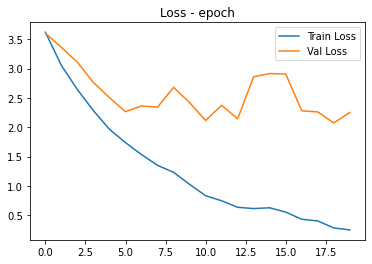

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(num_epochs), tr_loss, label="Train Loss")
plt.plot(range(num_epochs), v_loss, label="Val Loss")
plt.legend()
plt.title("Loss - epoch")
plt.show()

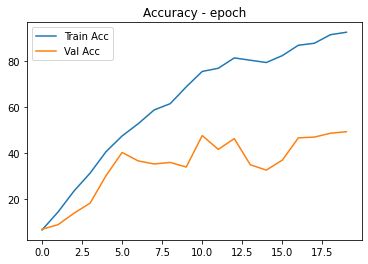

In [16]:
plt.plot(range(num_epochs), tr_acc, label="Train Acc")
plt.plot(range(num_epochs), v_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy - epoch")
plt.show()

In [17]:
test_model = CRNN(input_size, num_classes).to(device)

torch.save(model.state_dict(),"model.pth") 

test_model.load_state_dict(torch.load('model.pth'))
acc_list = []
test_model.eval()

# metrics
test_acc = 0
with torch.no_grad():
    for audio, label in test_loader:
        audio, label = audio.to(device), label.to(device)

        # forward pass
        out = test_model(audio)

        # acc
        _, pred = torch.max(out, 1)
        test_acc += (pred==label).sum()
        
    print(f'Accuracy: {test_acc.cpu().numpy()/len(test_set) * 100}%')

Accuracy: 50.33333333333333%
